# Confounds in functional MRI
As one of our reviewers noted, most decoding analyses (at least in cognitive neuroscience)
are done on functional MRI, as opposed to structural MRI like we used as our main example in
our paper (i.e., decoding gender from VBM/TBSS data). In this notebook, we simulate relatively
realistic fMRI data (i.e., temporally and spatially autocorrelated data) with and without a 
confound and see how our method (cross-validated confound regression) does and how it compares
to previously proposed methods (like by [Woolgar et al., 2014](https://www.sciencedirect.com/science/article/pii/S1053811914003395).

First, we'll focus on our simulating fMRI data.

## fMRI data simulation
Let's import some packages we need.

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from nistats.hemodynamic_models import spm_hrf
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr
from tqdm import tqdm_notebook
from confounds import ConfoundRegressor

%matplotlib inline

Now, we'll create a class, `FmriData`, that is able to generate data by convolving stimulus onsets with an HRF and subsequently estimate the activity estimates of our trials across a range of voxels.

In [2]:
class FmriData:
    """ Generates fMRI data.
     
    Parameters
    ----------
    P : int
        Number of conditions
    I : int
        Number of instances per condition
    I_dur : int
        Duration of trial in seconds (fixed across conditions, P)
    ISIs = list
        List of possible ISIs
    TR : int
        Time to repetition (must be int for simplicity)
    K : tuple
        Voxel dimensions
    ar_rho1 : float
        AR(p) autocorrelation of noise
    smoothness : int
        Spatial smoothing factor (in sigma of voxel dimensions)
    noise_factor : int/float
        How "strong" the noise is (scaling factor for noise covariance matrix V)
    cond_means : list
        List of length P with condition means of activation
    cond_stds : list
        List of length P with condition standard deviation of activation
    confound_corr : float
        Correlation of confound with conditions (assuming 2-class condition for simplicity). If None,
        no confound is simulated.
    """
 
    def __init__(self, P=2, I=20, I_dur=2, ISIs=(4, 5, 6, 7), TR=2, K=(3, 3),
                 ar1_rho=0.5, smoothness=2, noise_factor=1, cond_means=None, cond_stds=None,
                 conf_params=None, single_trial=True):
        """ Initializes FmriData object. """

        self.P = P
        self.I = I
        self.I_dur = I_dur
        self.ISIs = ISIs
        self.TR = TR
        self.K = K
        self.ar1_rho = ar1_rho
        self.smoothness=smoothness
        self.noise_factor = noise_factor
        self.cond_means = cond_means
        self.cond_stds = cond_stds
        self.single_trial = single_trial

        if conf_params is None:
            self.conf_params = dict(corr=0, mean=0, std=0)
        else:
            self.conf_params = conf_params
        
        self.X = None
        self.y = None
        self.conds = None
        self.conf = None
        self.V = None
        self.hrf = None
    
    def generate_data(self, X=None, single_trial=True):
        """ Generates timeseries fMRI data (X, y) with or without confound.
        
        Parameters
        ----------
        X : numpy array or None
            A numpy array of shape (timepoints x P) or (timepoints x (P*I)) for a
            single-trial design ("least-squares all", LSA) or None. When None,
            X is generated.
        single_trial : bool
            When False, the design has a separate regressor for each condition (p = 1 ... P).
            When True, the design has a separate regressor for each trial (i = 1 ... P * I)
            
        Returns
        -------
        X : numpy array
            A numpy array of shape (timepoints x P) or (timepoints x P*I)
        y : numpy array
            A numpy array of shape (timepoints x voxels)
        conds : numpy array
            A numpy array with condition labels (with P unique labels)
        true_betas : numpy array
            A numpy array with the true parameters used to generate the model
        """

        if X is None:  # Generate new X (else: use prespecified X)
            self._generate_X()

        self._generate_y()
        return self.X, self.y, self.conds, self.true_betas
    
    def _generate_conf(self, conds):
        
        weight = 0.0001
        desired_corr = self.conf_params['corr']
        conf = conds * weight + np.random.normal(0, 1, conds.size)
        this_corr = pearsonr(conf, conds)[0]
        while np.abs(this_corr - desired_corr) > 0.01:
            conf = conds * weight + np.random.normal(0, 1, conds.size)
            this_corr = pearsonr(conf, conds)[0]
            weight += 0.0001
    
        return conf
        
    def _generate_X(self):
        """ Generates X (design matrix). """
        
        single_trial = self.single_trial
        
        # Generate I trials for P conditions
        conds = np.repeat(np.arange(self.P), self.I)
        conds = np.random.permutation(conds)  # shuffle trials

        if len(conds) % len(self.ISIs) != 0:
            raise ValueError("Please choose ISIs which can spread across trials evenly.")

        # Generate ISIs and shuffle
        ISIs = np.repeat(self.ISIs, len(conds) / len(self.ISIs))
        ISIs = np.random.permutation(ISIs)
        run_dur = (np.sum(ISIs) + self.I_dur * len(conds))  # run-duration
        
        osf = 10  # oversampling factor for onsets/hrf
        if single_trial:  # nr of regressors = conditions * trials
            X = np.zeros((run_dur * osf, self.P*self.I))
        else:  # nr regressors = nr conditions
            X = np.zeros((run_dur * osf, self.P))

        current_onset = 0  # start creating onsets
        for i, trial in enumerate(conds):

            if single_trial:
                X[current_onset:(current_onset + self.I_dur * osf), i] = 1
            else:
                X[current_onset:(current_onset + self.I_dur * osf), trial] = 1

            this_ITI = self.I_dur * osf + ISIs[i] * osf
            current_onset += this_ITI
    
        # Define HRF
        if self.hrf is None:
            hrf = spm_hrf(tr=self.TR, oversampling=self.TR*osf,
                          time_length=32.0, onset=0.0)
            hrf = hrf / np.max(hrf)  # scale HRF, peak = 1
        else:
            hrf = self.hrf

        # If confound model is 'additive', create a regressor based on confound
        # and add to X to take care of convolution (to be used later when "controlling"
        # for its influence)
        if self.conf_params['corr'] != 0:
            conf = self._generate_conf(conds)
        else:
            conf = conds
            
        conf_pred = np.zeros(run_dur * osf)
        conf_pred[X.sum(axis=1) != 0] = np.repeat(conf, repeats=osf)
        X = np.c_[X, conf_pred]

        # Convolve regressors with HRF
        X = np.hstack([np.convolve(X[:, i], hrf)[:run_dur*osf, np.newaxis]
                       for i in range(X.shape[1])])
        
        X = X[::self.TR*osf, :]  # downsample
        X = np.c_[np.ones(X.shape[0]), X]  # stack intercept

        self.X = X
        self.conds = conds
        self.conf = conf
        
    def _generate_y(self):
        """ Generate signals (y). """
        
        X, conds, single_trial = self.X, self.conds, self.single_trial
        conf_mean, conf_std = self.conf_params['mean'], self.conf_params['std']

        N = X.shape[0]  # N = (downsampled) timepoints
    
        # Create ar1 covariance matrix and generate noise
        if self.V is None:
            self.V = self._generate_V(N)

        noise = np.random.multivariate_normal(np.zeros(N), self.V,
                                              size=np.prod(K)).T
        # Create condition means/stds
        if single_trial:
            # Extract actual means/stds based on condition
            cond_means = np.array([self.cond_means[i] for i in conds])
            cond_stds = np.array([self.cond_stds[i] for i in conds])
            
            cond_means = np.append(cond_means, conf_mean)
            cond_stds = np.append(cond_stds, conf_std)
        else:
            cond_means = self.cond_means
            cond_stds = self.cond_stds
        
        # Add intercept effects
        cond_means = np.append(0, cond_means)
        cond_stds = np.append(1, cond_stds)

        # Create true paramaters
        cov = np.eye(X.shape[1])
        cov *= cond_stds
        
        if single_trial:
            true_betas = np.random.multivariate_normal(cond_means.astype(float), cov, size=np.prod(K)).T
        else:
            true_betas = np.random.multivariate_normal(cond_means, cov, size=np.prod(K)).T

        # Create signal!
        y = X.dot(true_betas) + noise
        
        if self.smoothness is not None:  # Smooth if a smoothing kernel has been specified
            y = gaussian_filter(y.reshape((N,) + K), 1).reshape(N, np.prod(K))
  
        self.X = X
        self.y = y
        self.true_betas = true_betas
        
    def fit_glm(self, X=None, y=None, control_for_conf=False, remove_icept=True):
        """ Fits a GLM (using generalized least squares).
        
        Parameters
        ----------
        X : numpy array or None
            If numpy array, X should be a (timepoints x conditions/trials) array.
            If None, the attribute `X` of the object will be used.
        y : numpy array or None
            If numpy array, y should be a (timepoints x voxels) array. If
            None, the attribute `y` of the object will be used.
        control_for_conf : bool
            Whether to control for the confound in the first-level model. Only
            relevant for when confound_mod='additive' was used in data generation.
        remove_icept : bool
            Whether to remove the intercept from the statistics (betas, t-values, etc.)
            that will be returned
        
        Returns
        -------
        est_betas : numpy array
            Array with *estimated* (as opposed to *true*) parameters.
        stderrs : numpy array
            Array with standard errors of the estimated parameters.
        tvals : numpy array
            Array with t-values of the estimated parameters (against baseline)
        """
        
        if not control_for_conf:
            X = self.X[:, :-1]
        else:
            X = self.X

        est_betas = np.zeros((X.shape[1], y.shape[1]))
        stderrs = np.zeros_like(est_betas)
        tvals = np.zeros_like(est_betas)
        
        for i in range(y.shape[1]):  # loop over voxels
            
            gls_results = sm.GLS(y[:, i], X, sigma=self.V).fit()
            est_betas[:, i] = gls_results.params
            stderrs[:, i] = gls_results.bse
            tvals[:, i] = gls_results.tvalues

        if control_for_conf:  # remove confound from estimated parameters
            est_betas = est_betas[:-1, :]
            stderrs = stderrs[:-1, :]
            tvals = tvals[:-1, :]

        if remove_icept:  # remove intercept from estimated parameters
            est_betas = est_betas[1:, :]
            stderrs = stderrs[1:, :]
            tvals = tvals[1:, :]
        
        return est_betas, stderrs, tvals

    def _generate_V(self, N):
        """ Generates a autocovariance matrix based on a AR(p) model. """
        rho = self.ar1_rho
        cov = rho ** scipy.linalg.toeplitz(np.arange(N))
        return cov * self.noise_factor

    def plot(self, X, y, conds, voxel=(0, 0)):
        """ Plots the design and signal of a particular voxel from a particular run. """
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharex=True)
        
        ax[0].set_prop_cycle('color', [plt.cm.Dark2(i) for i in conds])
        ax[0].plot(X[:, 1:])
        ax[0].axhline(0, ls='--', c='k', lw=1)
        ax[0].set_xlim(0, X.shape[0])
        ax[0].set_xlabel('Time (in dynamics)', fontsize=15)
        ax[0].set_ylabel('Amplitude (a.u.)', fontsize=15)

        yresh = y.reshape((y.shape[0],) + self.K)
        ax[1].plot(yresh[:, voxel[0], voxel[1]])
        ax[1].axhline(0, ls='--', c='k', lw=1)
        ax[1].set_xlabel('Time (in dynamics)', fontsize=15)
        
        sns.despine()
        fig.tight_layout()
        fig.show()

So, how does this work? Well, for our purposes, we'll generate the signal(s), $y$, as function of the design, $X$, the true parameters, $\beta$, and noise, $\epsilon$, in the following manner:

\begin{align}
y = X\beta + \epsilon
\end{align}

Here, we generate $\epsilon$ from a multivariate normal distribution with mean $\mu = 0$ and covariance matrix $V$:

\begin{align}
\epsilon \sim N(0, V)
\end{align}

V is assumed to follow an AR(p) model.

Then, we generate $\beta$ from a $K$-dimensional (number of voxels) multivariate normal distribution with means $\mu$ and covariance matrix $\sigma I$, where $I$ is the identity matrix (i.e., the true parameters $\beta$ are uncorrelated across voxels, but may differ in variance):

\begin{align}
\beta \sim N(\mu, \sigma I)
\end{align}

Lastly, $X$ is constructed as a set of regressors (one for each trial) that are the result of a convolution of a finite impulse response and an HRF:

\begin{align}
X_{j} = conv(X_{j}, HRF) 
\end{align}

## Generating null-data
Alright, so let's specify some parameters for our experiment. We'll make sure it represents null-data (no effect; i.e., no reliable difference between voxels patterns across $P$ conditions):

In [3]:
P = 2  # conditions
I = 40  # trials per condition
I_dur = 1  # trial-duration in seconds
ISIs = [5, 7]  # possible inter-stimulus-intervals
TR = 2  # in seconds
K = (10, 10)  # voxels
ar1_rho = 0.5  # autocorrelation for AR1(p) process
smoothness = 1  # spatial smoothness in sigma
noise_factor = 1  # scaling for V
cond_means = (0, 0)  # condition means
cond_stds = (0.5, 0.5)  # condition stds
single_trial = True  # generate using LSA?

Alright, now let's check whether it's really null data. We'll simulate data 100 times and check the average decoding accuracy:

HBox(children=(IntProgress(value=0), HTML(value='')))

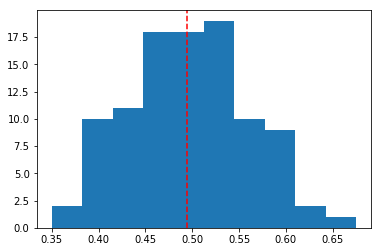

Mean accuracy across iterations: 0.494


In [4]:
fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                    K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                    noise_factor=noise_factor, cond_means=cond_means,
                    cond_stds=cond_stds, single_trial=single_trial)

pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    
iters = 100
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):
    
    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
    #pipe = make_pipeline(ConfoundRegressor(X=b, confound=conf), StandardScaler(), SVC(kernel='linear'))

    mean_acc[i] = cross_val_score(pipe, tvals, conds, cv=10).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

Alright, that checks out! Now, just to be sure, let's simulate data with some effect (i.e., difference in patterns between conditions). We'll set the condition means to -0.1 and +0.1. This should increase our decoding accuracy.

HBox(children=(IntProgress(value=0), HTML(value='')))

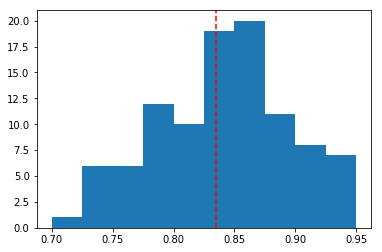

Mean accuracy across iterations: 0.835


In [5]:
cond_means = (-0.1, 0.1)

fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                    K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                    noise_factor=noise_factor, cond_means=cond_means,
                    cond_stds=cond_stds, single_trial=single_trial)

pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))

iters = 100
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):
    
    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y)
    mean_acc[i] = cross_val_score(pipe, tvals, conds, cv=10, n_jobs=2).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

This makes sense! Now, let's check out what happens when we include a confound.

## Generating data with a confound
Now, we'll simulate some data affected by a confound. To generate the data, we'll use the "additive" model from the Woolgar et al. article. In this model, they assume the confound has some additive effect on the true activation parameters of each voxel. Accordingly, we generate the data as:

\begin{align}
y = X\beta_{X} + C\beta_{C} + \epsilon
\end{align}

where $C$ is an array of shape ($N \times 1$) representing the confound onsets convolved with an HRF. In our data generation, $C$ can be generated with a prespecified correlation to the conditions and the weight ($\beta_{C}$) is drawn from a normal distribution:

\begin{align}
\beta_{C} \sim N(\mu_{\beta_{C}}, \sigma_{\beta_{C}})
\end{align}

Think of $C$ like something as reaction time that may have an additional effect on voxels that (may or may not) encode something like rules (like in the original Woolgar article). Now, we'll set the condition means to zero again to simulate some null-data, but we're also setting the correlation between the confound and the true conditions to 0.5, so we expect based on the confound alone that the decoding accuracy will be higher.

HBox(children=(IntProgress(value=0), HTML(value='')))

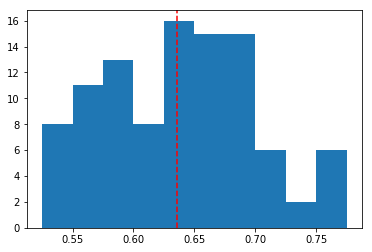

Mean accuracy across iterations: 0.636


In [6]:
cond_means = (0, 0)
conf_params = dict(corr=0.5, mean=1, std=0)

fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                    K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                    noise_factor=noise_factor, cond_means=cond_means,
                    cond_stds=cond_stds, conf_params=conf_params,
                    single_trial=single_trial)

pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))

iters = 100
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):

    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y)
    mean_acc[i] = cross_val_score(pipe, tvals, conds, cv=10, n_jobs=2).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

This is expected! Now, how to control for this influence? We can of course use confound regression! Let's actually test both WDCR and CVCV. We expect, given the result from the main paper, that WDCR will yield negative bias while CVCR will yield relatively unbiased results.

### WDCR

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

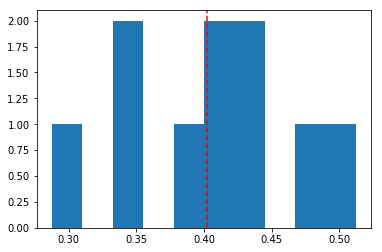

Mean accuracy across iterations: 0.403


In [44]:
conf_params = dict(corr=0.5, mean=1, std=0)

fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                    K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                    noise_factor=noise_factor, cond_means=cond_means,
                    cond_stds=cond_stds, conf_params=conf_params,
                    single_trial=single_trial)

iters = 10
mean_acc = np.zeros(iters)
pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))
for i in tqdm_notebook(range(iters)):

    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
    cfr = ConfoundRegressor(X=tvals, confound=fmri_gen.conf)
    tvals = cfr.fit_transform(tvals)
    mean_acc[i] = cross_val_score(pipe, tvals, conds, cv=10).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

As expected: below-chance classification. 

## CVCV
Now, let's try CVCR (cross-validated confound-regression).

HBox(children=(IntProgress(value=0), HTML(value='')))

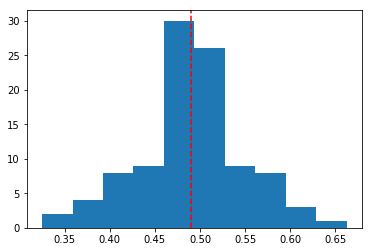

Mean accuracy across iterations: 0.490


In [46]:
conf_params = dict(corr=0.5, mean=1, std=0)

fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                    K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                    noise_factor=noise_factor, cond_means=cond_means,
                    cond_stds=cond_stds, conf_params=conf_params,
                    single_trial=single_trial)

iters = 100
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):

    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
    pipe = make_pipeline(ConfoundRegressor(X=tvals, confound=fmri_gen.conf),
                         StandardScaler(), SVC(kernel='linear'))

    mean_acc[i] = cross_val_score(pipe, tvals, conds, cv=10).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

That looks good!

## Autocorrelated patterns
One reviewer was interested in how CVCR would behave when patterns would be more or less autocorrelated. We can vary autocorrelation in our data generation process easily by varying the ISIs between trials: shorter ISIs will yield more autocorrelation between patterns. Let's verify this by plotting the correlation matrix between patterns for various ISIs. We expect to see "brighter" values around the diagonal for short ISIs.

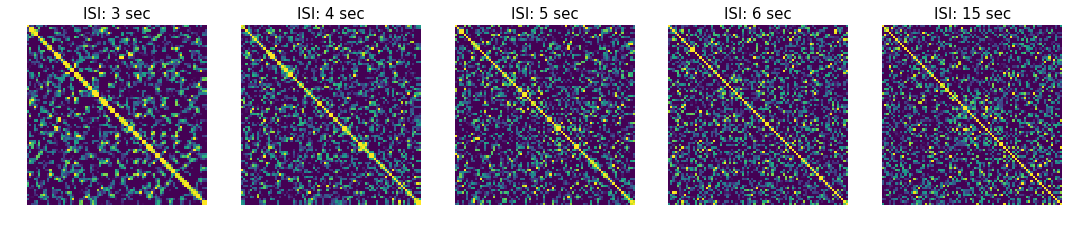

In [81]:
these_ISIs = [[3], [4], [5], [6], [15]]
plt.figure(figsize=(15, 5))
for i, ISIs in enumerate(these_ISIs):
    
    fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                    K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                    noise_factor=0.5, cond_means=cond_means,
                    cond_stds=cond_stds, conf_params=None,
                    single_trial=single_trial)
    
    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True)
    
    pattern_corrs = np.corrcoef(tvals)
    plt.subplot(1, len(these_ISIs), i+1)
    # Note the scaling: this emphasises the contrast between high and 
    # low correlations
    plt.imshow(pattern_corrs, vmin=0, vmax=0.5)
    plt.axis('off')
    plt.title("ISI: %i sec" % ISIs[0], fontsize=15)
    
plt.tight_layout()
plt.show()

You can clearly see that the patterns are more autocorrelated for short ISIs. (Note that for lower ISIs, the first-level model becomes non-invertible.)

Now, how does CVCR do with these different types of data?

In [102]:
these_ISIs = [[3], [4], [5], [6], [15]]
results = dict(acc=[], ISI=[], regress=[])

conf_params = dict(corr=0.8, mean=1, std=0)
for i, ISIs in enumerate(these_ISIs):
    
    fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                        K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                        noise_factor=noise_factor, cond_means=cond_means,
                        cond_stds=cond_stds, conf_params=conf_params,
                        single_trial=single_trial)

    iters = 10
    for ii in tqdm_notebook(range(iters)):

        X, y, conds, true_params = fmri_gen.generate_data()
        betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True)
        pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))
        acc = cross_val_score(pipe, tvals, conds, cv=10).mean()
        results['ISI'].append(ISIs[0])
        results['acc'].append(acc)
        results['regress'].append(False)
        
        pipe = make_pipeline(ConfoundRegressor(X=tvals, confound=fmri_gen.conf),
                             StandardScaler(), SVC(kernel='linear'))

        acc = cross_val_score(pipe, tvals, conds, cv=10).mean()
        results['ISI'].append(ISIs[0])
        results['acc'].append(acc)
        results['regress'].append(True)
        

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

Plot the results:

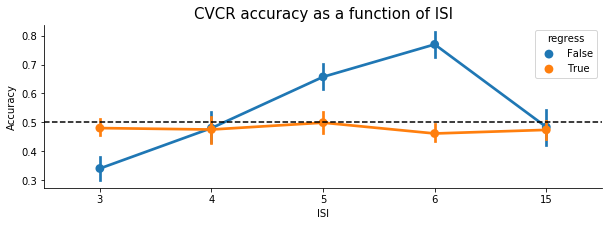

In [103]:
df = pd.DataFrame(results)

plt.figure(figsize=(10, 3))
ax = sns.pointplot(data=df, x='ISI', y='acc', hue='regress')
ax.set_xlabel("ISI")
ax.set_ylabel('Accuracy')
ax.axhline(0.5, ls='--', c='k')
sns.despine()
ax.set_title('CVCR accuracy as a function of ISI', fontsize=15)
plt.show()

Great, this seems to work! (Interestingly, there seems to be substantial below-chance classification for low ISIs when you *don't* regress out the confound! So it seems that confound regress has some kind of normalizing influence on the data, at least for low ISIs. This is even more the case when you reduce the correlation between the confound and the target!)

## Control for confound during pattern estimation
Alternatively, we can use the method advocated in the Woolgar article by simply adding the (HRF-convolved) confound to the first-level model in which we estimate the activity parameters. In our `FmriData` class, we can simply set `control_for_conf` to true to do this (given that the data was actually generated with a confound in mind using the 'additive' method). This will add the confound to the model and return the parameters "adjusted" for the confound. Let's run that:

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

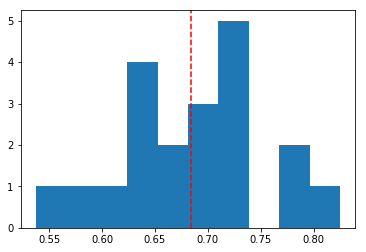

Mean accuracy across iterations: 0.684


In [108]:
conf_params = dict(corr=0.8, mean=1, std=0)
ISIs = [5, 7]
fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                    K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                    noise_factor=noise_factor, cond_means=cond_means,
                    cond_stds=cond_stds, conf_params=conf_params,
                    single_trial=single_trial)

pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))

iters = 20
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):

    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True)
    mean_acc[i] = cross_val_score(pipe, betas, conds, cv=10).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

Heh, that's weird. It seems that this method yields quite some positive bias (i.e., higher accuracy than expected) ... What's going on here? Before speculating any further, perhaps this is due to the specific correlation we chose (0.8) - let's redo this for a range of correlations between the conditions and the confound (from 0 - 1):

In [109]:
corrs = np.arange(0, 1.05, 0.1) # from 0 - 1 in steps of 0.1
results = dict(acc=[], corr=[])

for i, corr in enumerate(corrs):
    
    conf_params = dict(corr=corr, mean=1 if corr != 0 else 0, std=0)

    fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                        K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                        noise_factor=noise_factor, cond_means=cond_means,
                        cond_stds=cond_stds, conf_params=conf_params,
                        single_trial=single_trial)

    pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))

    iters = 10
    for ii in tqdm_notebook(range(iters)):

        X, y, conds, true_params = fmri_gen.generate_data()
        betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True)
        acc = cross_val_score(pipe, tvals, conds, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

And let's plot it:

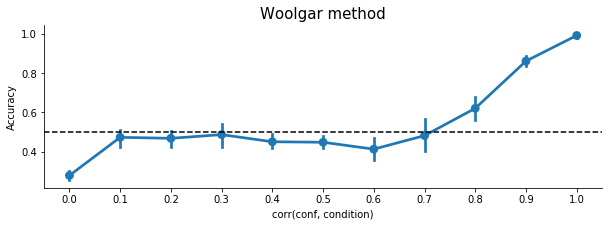

In [110]:
df = pd.DataFrame(results)
df['corr'] = df['corr'].round(2)

plt.figure(figsize=(10, 3))
ax = sns.pointplot(data=df, x='corr', y='acc')
ax.set_xlabel("corr(conf, condition)")
ax.set_ylabel('Accuracy')
ax.axhline(0.5, ls='--', c='k')
sns.despine()
ax.set_title('Woolgar method', fontsize=15)
plt.show()

Hmm, very weird! For very low correlation values, it yields negative bias and for high values (>0.7) it seems to yield positive bias! What's going on? Actually, the reviewer that suggested to look into this method offered a potential explanation: positive bias may occur due to variance decoding ([Hebart & Baker, 2017](https://www.ncbi.nlm.nih.gov/pubmed/28782682)). Variance decoding occurs when decoding is not, technically, due to any mean difference between conditions, but due to differences in variance. As suggested by the reviewer, high correlations between the confound and the condition may inflate the variance of the pattern estimates due to an (uneven) increase in covariance between trials and the confound (note that the covariance of parameters in the GLM depend on both the variance and the covariance, as is evident from the $\sigma (X^{T}X)^{-1}$ term).

In [114]:
corrs = np.arange(0, 1.05, 0.1) # from 0 - 1 in steps of 0.1
results = dict(acc=[], corr=[], mod=[])

for i, corr in enumerate(corrs):
    
    conf_params = dict(corr=corr, mean=1 if corr != 0 else 0, std=0)

    fmri_gen = FmriData(P=P, I=I, I_dur=I_dur, ISIs=ISIs, TR=TR,
                        K=K, ar1_rho=ar1_rho, smoothness=smoothness,
                        noise_factor=noise_factor, cond_means=cond_means,
                        cond_stds=cond_stds, conf_params=conf_params,
                        single_trial=single_trial)

    pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))

    iters = 10
    for ii in tqdm_notebook(range(iters)):

        X, y, conds, true_params = fmri_gen.generate_data()
        betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True)
        acc = cross_val_score(pipe, tvals, conds, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['mod'].append('tval')
        
        acc = cross_val_score(pipe, stders, conds, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['mod'].append('stderr')


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

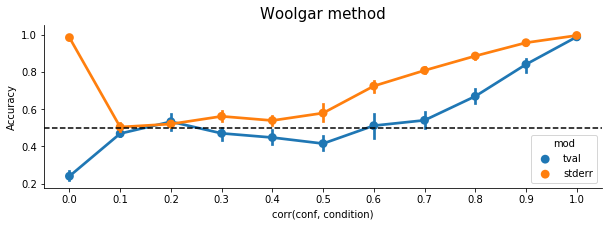

In [115]:
df = pd.DataFrame(results)
df['corr'] = df['corr'].round(2)

plt.figure(figsize=(10, 3))
ax = sns.pointplot(data=df, x='corr', y='acc', hue='mod')
ax.set_xlabel("corr(conf, condition)")
ax.set_ylabel('Accuracy')
ax.axhline(0.5, ls='--', c='k')
sns.despine()
ax.set_title('Woolgar method', fontsize=15)
plt.show()